In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import networkx as nx
import scipy
import itertools

In [2]:
file = r"C:\Users\PcLaptop\Dropbox (Politecnico Di Torino Studenti)\ISI\2020-04-20-2023-04-20.csv"
df = pd.read_csv(file)

In [5]:
df = df.loc[df["region"] == "Caucasus and Central Asia"]

In [12]:
df.groupby(["country"])["fatalities"].sum()

country
Afghanistan     72251
Armenia           276
Azerbaijan       7163
Georgia             1
Kazakhstan        228
Kyrgyzstan        104
Tajikistan         97
Turkmenistan        1
Uzbekistan         30
Name: fatalities, dtype: int64

In [6]:
v= df["event_date"]
v=v.values
dt = [datetime.strptime(v[i], "%d %B %Y") for i in range(len(v))]
q=[]

for i in range(len(dt)):
    q.append(datetime.timestamp(dt[i]))
    
df.insert(loc=3, column='date_timestamp', value=q)
df = df.sort_values("date_timestamp")

In [14]:
dk=df.groupby(["country"])["fatalities"].sum()
country = dk[dk>0].index.tolist()
#dk

In [8]:
vec_df =[]
for c in country:
    df2 = df.copy()
    df2.loc[df2["country"] != c, df2.columns != "date_timestamp"] = 0
    vec_df.append(df2)

In [9]:
G = nx.Graph()
time_series=[]
res = {i: country[i] for i in range(len(country))}

for i in range(len(country)):
    G.add_node(i)
    index= vec_df[i].groupby("date_timestamp").count()["event_id_cnty"].index.values.tolist() 
    numb= vec_df[i].groupby("date_timestamp")["fatalities"].sum().to_list()
    vec_t=[index,numb]
    time_series.append(np.transpose(vec_t))
       
nx.set_node_attributes(G,{ n: time_series[n] for n in G.nodes() },'ts')
nx.set_node_attributes(G,{ n: res[n] for n in G.nodes() },'country')

edges = {(u,v): abs(scipy.stats.pearsonr(time_series[u][:,1].tolist(), time_series[v][:,1].tolist())[0]) 
         for u,v in itertools.combinations(range(len(country)), 2) 
         if abs(scipy.stats.pearsonr(time_series[u][:,1].tolist(), time_series[v][:,1].tolist())[0])>0.05}
G.add_edges_from(edges)
nx.set_edge_attributes(G, values = edges, name = 'weight')

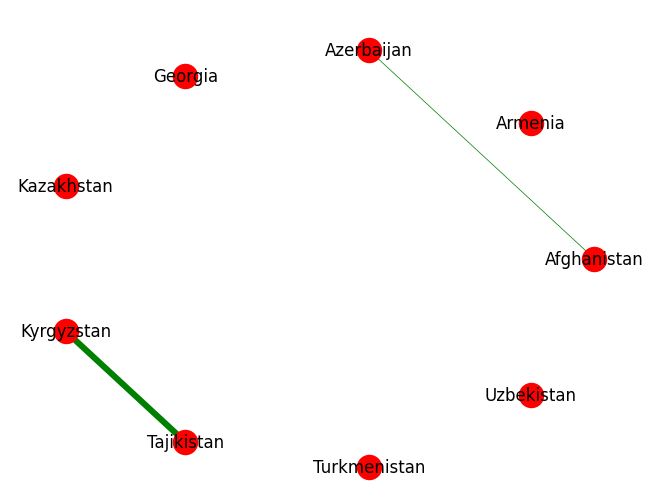

In [10]:
weight=nx.get_edge_attributes(G, "weight").values()
nx.draw(G, nx.circular_layout(G), width=[list(weight)[i]*5 for i in range(len(list(weight)))], edge_color="g",node_color="r", labels=res)
plt.show()

In [11]:
degree_centrality = nx.degree_centrality(G)
print(degree_centrality)

{0: 0.125, 1: 0.0, 2: 0.125, 3: 0.0, 4: 0.0, 5: 0.125, 6: 0.125, 7: 0.0, 8: 0.0}
